# PHYS20762 - Project 3 - Monte Carlo Techniques - Neutron Transport and Scattering Through a Shielding Layer

Euan Baldwin - 10818421<br>
University of Manchester  
May 2023

## Introduction

In this project, we will develop a Monte Carlo simulation to study the transport and scattering of thermal neutrons through a shielding layer of various materials, such as water, lead, and graphite.

First, we will generate random numbers using Python's built-in `np.random.uniform` function and ensure the uniformity of the generated numbers using interactive scatter plots. Next, we will develop a random number generator that generates samples distributed according to an exponential function.

We will then create a function that generates isotropic unit vectors, followed by another function that generates isotropic steps with lengths distributed according to the exponential function. These functions will be used to simulate the random walk of neutrons through different materials.

After developing these preliminary functions, we will create a program that simulates the behaviour of neutrons as they travel through water, lead, and graphite under various conditions. We will determine the macroscopic absorption and scattering cross-sections, as well as the total mean free path ($\lambda$), for each material. We will visualize the random walk of a few neutrons through each material and calculate the absorption, reflection, and transmission rates for a large number of neutrons.

We will then investigate the variation in neutron transmission, reflection, and absorption rates with slab thickness for the three materials and determine their characteristic attenuation lengths and estimated errors. As a bonus task, we will implement the Woodcock method to calculate the fraction of neutrons transmitted through two slabs of different materials in contact with each other.  We will also extend the project by implementing the woodcock method for N slabs of varied thicknesses.

Throughout the project, we will validate our results using visualizations and comparisons with known data to ensure the accuracy and reliability of our simulations.

## Applications

The Monte Carlo simulation of neutron transport and scattering through shielding materials has a wide range of real-world applications. Some of the most important applications are:

1. Nuclear power plants: Can be used to design shielding materials for nuclear power plants to protect workers from harmful radiation. By simulating the behaviour of neutrons through different materials, engineers can determine the most effective materials for reducing radiation exposure.

2. Medical imaging and radiation therapy: The shielding of X-rays and gamma rays is essential to protect healthy tissue and organs from the harmful effects of radiation. Monte Carlo simulations can help to optimise the design of radiation shields and assess the effectiveness of different materials.

3. Particle accelerators: Neutrons are generated as a by product of the nuclear reactions that occur when particles collide. The neutron transport simulation can be used to design effective shielding materials to protect workers from neutron radiation.

4. Oil and gas exploration: Neutron logging tools are used to measure the properties of subsurface rock formations. Monte Carlo simulations can help to optimise the design of these tools and assess the effectiveness of different materials for shielding the detectors from unwanted radiation.

Overall, the Monte Carlo simulation of neutron transport and scattering has numerous practical applications in various fields, where the shielding of radiation is critical to protect people and equipment from harmful effects.

## Initialisation

We first initialise the Python interpreter and import the necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from scipy.constants import N_A
import time
from tqdm.auto import tqdm
from IPython.display import HTML, Image

Define the constants, and store the names and values fo each material in dictionaries, using the name of the material as the key.

In [2]:
# Start the execution timer
START_TIME = time.time()

# Constants
AVOGADRO = N_A * 10 ** (-24) # Scaled avogadro constant ≈ 0.6022 
SAMPLE_SIZE = 10000
BIN_NUMBER = 100
N_REPEATS = 10

materials = ["Water", "Lead", "Graphite", "Vacuum"]
absorption_cross_sections = {"Water": 0.6652, "Lead": 0.158, "Graphite": 0.0045} # barns (1 barn = 10^-28 m^2)
scattering_cross_sections = {"Water": 103.0, "Lead": 11.221, "Graphite": 4.74} # barns
densities = {"Water": 1.00, "Lead": 11.35, "Graphite": 1.67} # g/cm^3
molar_masses = {"Water": 18.0153, "Lead": 207.2, "Graphite": 12.011} # g/mol

## Testing Random Number Generators

Generating truly random numbers in computing is challenging because computers operate on a deterministic basis, meaning that they are designed to follow predefined rules and processes, which are not inherently random. Most computers generate random numbers using algorithms that simulate randomness. These algorithms, called pseudo-random number generators, produce numbers that appear to be random, but are actually generated using a mathematical formula.

#### Testing `np.random.uniform`

The uniform distribution generated by `np.random.uniform` is a continuous probability distribution where all values in the range have an equal probability of being generated. 

The np.random.uniform() function is implemented using a mathematical formula that transforms a seed value into a sequence of seemingly random numbers. The seed value is typically derived from the system clock or other sources of entropy. While the numbers generated by the `np.random.uniform` function are not truly random, they are sufficiently random for most practical purposes and can be used in simulations, games, and other applications that require random numbers.

The function will be visually tested by generating an animated histogram of a uniform sample that periodically updates to show the random variations.

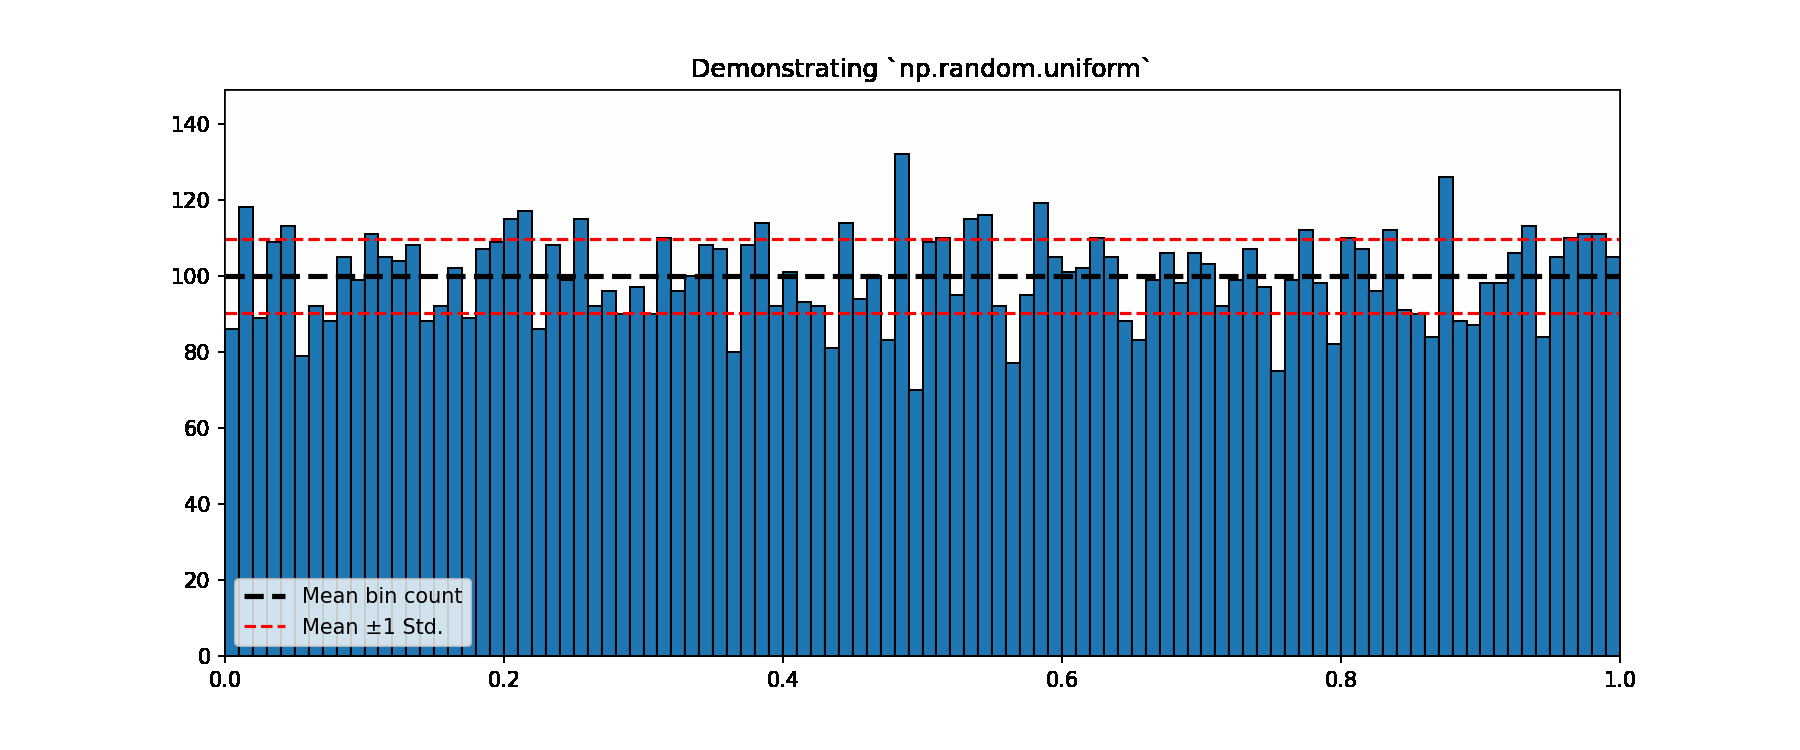

In [3]:
def histogram_initial(ax):
    # Generate random data uniformly distributed between 0 and 1
    data = np.random.uniform(size=SAMPLE_SIZE)

    # Plot the histogram with specified number of bins
    counts, _, bars = ax.hist(data, BIN_NUMBER, ec="black")
    
    # Plot a line showing the mean bin count
    mean_bin_count = np.mean(counts)
    std_bin_count = np.std(counts)
    ax.axhline(mean_bin_count, c='k', ls='--', label='Mean bin count', lw=2.5)
    ax.axhline(mean_bin_count + std_bin_count, c='r', ls='--', label='Mean ±1 Std.')
    ax.axhline(mean_bin_count - std_bin_count, c='r', ls='--')
    
    # Configure the plot
    ax.set_ylim(top=(mean_bin_count + 5 * std_bin_count))
    ax.set_xlim(0, 1)
    ax.set_title("Demonstrating `np.random.uniform`")
    ax.legend(loc='lower left')

    return bars


def histogram_update(frame, ax, bars):
    # Generate new random data uniformly distributed between 0 and 1
    data = np.random.uniform(size=SAMPLE_SIZE)

    # Calculate histogram values for the new data
    n, bins = np.histogram(data, BIN_NUMBER)

    # Update the height of each bar
    for bar, height in zip(bars, n):
        bar.set_height(height)

    return bars


def histogram_animate():
    # Create a figure and axis for the plot
    fig, ax = plt.subplots(figsize=(12, 5))

    # Initialise the histogram plot
    bars = histogram_initial(ax)

    # Create the animation object using the update function
    ani = animation.FuncAnimation(fig, histogram_update, frames=5, fargs=(ax, bars), interval=1000, repeat=True)

    # Save the animation as an animated GIF with the desired DPI
    ani.save('animation.gif', writer='pillow', dpi=150)

    # Close the figure to prevent displaying the static plot
    plt.close(fig)

# Call the function to animate the histogram and store the FuncAnimation object in a variable
histogram_animate()

# Display the animated GIF
Image(filename='animation.gif')

The above plot visually demonstrates that `np.random.uniform` generates pseudo-random numbers, suitable for use in the neutron simulation.

#### Investigating spectral lines

The `RandSsp` Multiplicative Congruential Generator (MCG) is a type of uniform random number generator that uses a mathematical formula to generate a sequence of random numbers. It is based on the parameters used by IBM's Scientific Subroutine Package, that IBM used in several libraries in the 1960's. The MCG works by multiplying the previous number in the sequence by a constant, then adding another constant, and taking the result modulo a third constant to obtain the next number in the sequence.

In higher dimensions, the MCG can exhibit spectral lines, which are patterns that occur when certain sequences of numbers in the generated sequence have a higher correlation than others. The presence of spectral lines in the MCG is due to the fact that the formula used to generate the numbers is a linear operation, and linear operations tend to create patterns in higher dimensions.

In contrast, the `np.random.uniform` function uses a different approach to generating random numbers. It is based on a different algorithm that does not exhibit spectral lines, because it involves a more complex transformation of the initial seed value to obtain the random numbers.

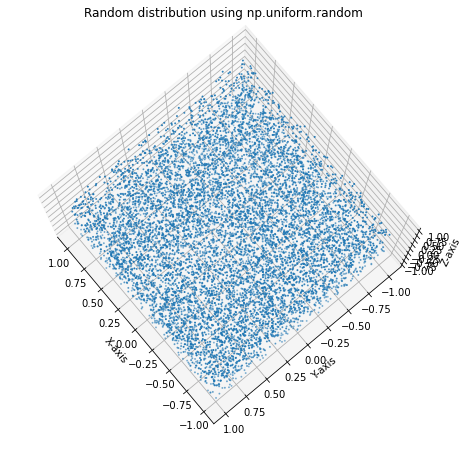

In [4]:
def gen_random_3d_dataset(num_samples):
    # Generate random data uniformly distributed between -1 and 1 for each of x, y and z
    x = np.random.uniform(-1, 1, num_samples)
    y = np.random.uniform(-1, 1, num_samples)
    z = np.random.uniform(-1, 1, num_samples)
    return x, y, z


def plot_3d_scatter(x, y, z, title):
    # Plot an interactive 3D scatter graph
    fig = plt.figure(figsize=(12, 6))
    ax = Axes3D(fig)
    ax.scatter(x, y, z, s=1)

    # Configure plot settings
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    ax.set_box_aspect(aspect=(1, 1, 1))
    ax.view_init(elev=81, azim=140)
    ax.set_title(title)

    # Display the plot
    plt.show()


# Generate a random 3D dataset with SAMPLE_SIZE samples
xdata, ydata, zdata = gen_random_3d_dataset(SAMPLE_SIZE)

# Plot the dataset in a 3D scatter plot
plot_3d_scatter(xdata, ydata, zdata, "Random distribution using np.uniform.random")

The above plot visually demonstrates that `np.random.uniform` doesn't produce spectral lines and is hence suitable for use in the neutron simulation.

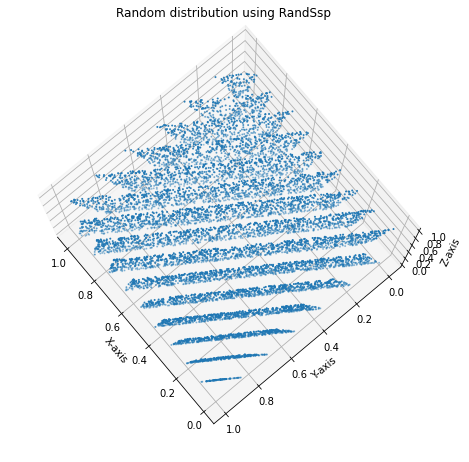

In [5]:
def randssp(p,q):

    global m, a, c, x

    m = pow(2, 31)
    a = pow(2, 16) + 3
    c = 0
    x = 123456789

    try: p
    except NameError:
        p = 1
    try: q
    except NameError:
        q = p

    r = np.zeros([p,q])

    for l in range (0, q):
        for k in range (0, p):
            x = np.mod(a*x + c, m)
            r[k, l] = x/m

    return r


k = randssp(3, SAMPLE_SIZE)

plot_3d_scatter(k[0, :], k[1, :], k[2, :], "Random distribution using RandSsp")

The above plot visually demonstrates that `RandSsp` does produce spectral lines and is hence unsuitable for use in the neutron simulation. 

#### Note that the plot is not interactive as this causes issues with other plots. Dr Mohammad Saeed Bahramy confirmed that it was ok to plot all plots inline (non-interactive) as long as the spectral issues can clearly by seen.

## Characteristic Attenuation Length of Water - Assuming No Scattering

To create a random number generator that produces samples distributed according to an exponential function $e^{-\frac{x}{\lambda}}$, where $\lambda$ is the mean free path, we can use the inverse transform method. The basic idea of the inverse transform method is to transform a uniform distribution of random numbers into the desired distribution using the inverse cumulative distribution function (CDF). For the exponential distribution, the CDF is given by:

$$F(x) = 1 - e^{-\frac{x}{\lambda}}.$$

Solving for the inverse of the CDF, we get: 

$$F^{-1}(u) = -\lambda \ln(1 - u)$$

hence a sample is given by: 

$$s_{i}=-\lambda_{T}\ln{u_{i}}$$

where ${u_{i}}$ is a random number between 0 and 1 generated using `np.random.uniform` function. Using this formula, we can generate a sample from an exponential distribution with a mean free path of $\lambda$, which is given by

$$\lambda = \frac{1}{\frac{\rho \sigma_{a} * N}{M}}$$

where $\rho$ is the density of the material, $\sigma_{a}$ is the absorption cross section, $N$ is the Avogadro constant (scaled to account for the other units being in barns) and $M$ is the molar mass.

To demonstrate the characteristic attenuation length (length at which beam intensity has fallen by Euler's number) for water in the absence of scattering, we can use this random number generator to simulate the attenuation of neutrons through a slab of water of a known thickness. We can assume that the probability of absorption of a neutron in water is given by the Beer-Lambert law, which states that the intensity of a beam of radiation decreases exponentially with the distance travelled through a material, as:

$$I(d)=I_0 e^{-\frac{d}{\lambda_{cal}}} $$

where $I(d)$ is the intensity of the beam after travelling a distance $d$ through the material, $I_0$ is the initial intensity, and $\lambda_{cal}$ is the characteristic attenuation length.

We can simulate the attenuation of neutrons through a slab of water by generating a large number of random numbers using the exponential distribution generator and calculating the distance travelled by each neutron through the slab until it is absorbed. By averaging the distances travelled by all the neutrons, we can estimate the characteristic attenuation length of water.

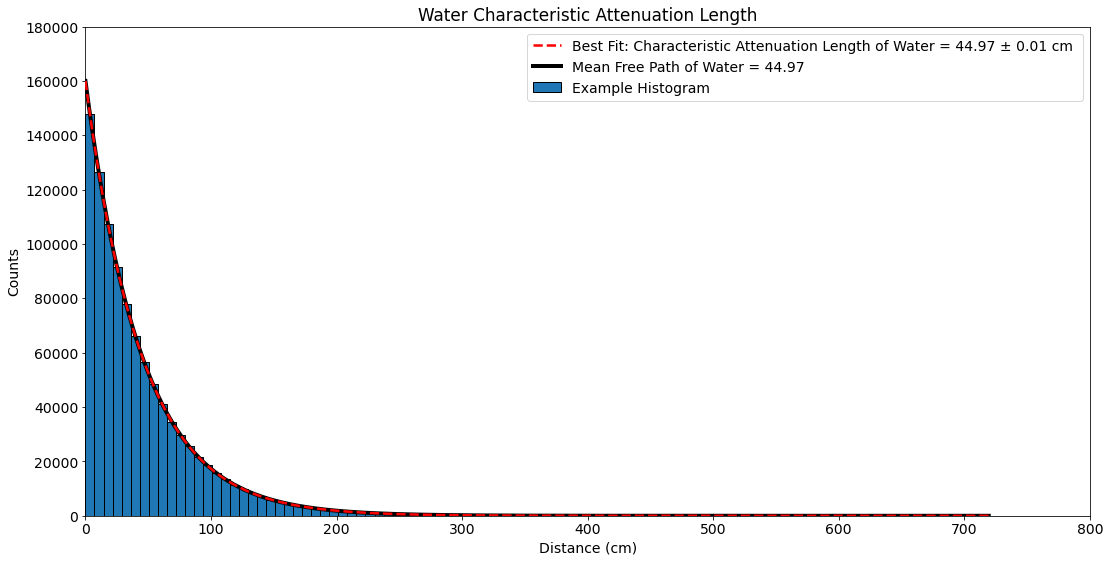

In [6]:
def mean_free_path_absorption(material):
    # Calculate absorption cross section for given material
    absorption_cross_section_macro = (densities[material] * absorption_cross_sections[material]
                                / molar_masses[material] * AVOGADRO)

    # Calculate mean free path
    mean_free_path = 1 / absorption_cross_section_macro
    return mean_free_path


def gen_exponential_dataset(num_samples, mean_free_path):
    # Generate random numbers uniformly distributed between 0 and 1
    x = np.random.uniform(0, 1, num_samples)

    # Transform the uniform random numbers into an exponential distribution
    step_lengths = - mean_free_path * np.log(x)
    return step_lengths


def generate_histogram(num_samples, mean_free_path, num_bins, n_repeats):
    data = gen_exponential_dataset(num_samples, mean_free_path) # Generate exponential dataset
    counts, bin_edges = np.histogram(data, bins=num_bins) # Create histogram data
    return counts, bin_edges


def fitting(num_samples, mean_free_path, num_bins, n_repeats):
    attenuation_lengths = np.zeros(n_repeats)

    # Perform fits for each repeat
    for i in range(n_repeats):
        counts, bin_edges = generate_histogram(num_samples, mean_free_path, num_bins, n_repeats)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

        # Discard zero counts
        non_zero_counts = counts[counts > 0]
        non_zero_bin_centers = bin_centers[counts > 0]

        # Define the weighting as the sqrt of the non-zero counts
        weights = np.sqrt(non_zero_counts)

        # Perform weighted least-squares fit
        popt = np.polyfit(non_zero_bin_centers, np.log(non_zero_counts), 1, w=weights)

        attenuation_length = -1 / popt[0]
        attenuation_lengths[i] = attenuation_length

    # Calculate the mean attenuation length and its uncertainty
    attenuation_length_mean = np.mean(attenuation_lengths)
    attenuation_length_uncertainty_overall = np.std(attenuation_lengths) / np.sqrt(n_repeats)

    return attenuation_length_mean, attenuation_length_uncertainty_overall


def plot_histogram(num_samples, num_bins, n_repeats, material):
    fig = plt.figure(figsize=(18, 9))
    plt.rcParams.update({'font.size': 14}) # Set the text size to 14

    # Calculate the mean free path of the material 
    mean_free_path = mean_free_path_absorption(material)

    # Get the fitted attenuation length and its uncertainty
    attenuation_length, attenuation_length_uncertainty = fitting(
        num_samples, mean_free_path, num_bins, n_repeats)
    
    # Plot an example histogram
    data = gen_exponential_dataset(num_samples, mean_free_path)
    counts, bin_edges, _ = plt.hist(data, num_bins, ec='k', label='Example Histogram')

    # Calculate the bin width of the example histogram
    bin_width = bin_edges[1] - bin_edges[0]

    # Plot the best-fit line
    x = np.linspace(0, max(bin_edges), SAMPLE_SIZE)
    y = np.exp(- x / attenuation_length) / attenuation_length
    y *= sum(counts) * bin_width
    plt.plot(x, y, label=f'Best Fit: Characteristic Attenuation Length of Water = {attenuation_length:.2f}'
             f' ± {attenuation_length_uncertainty:.2f} cm ', ls='--', zorder=10, c='r', lw=2.5)

    # Plot the actual line
    atten_length_actual = mean_free_path_absorption(material)
    y_actual = np.exp(- x / atten_length_actual) / atten_length_actual
    y_actual *= sum(counts) * bin_width
    plt.plot(x, y_actual, lw=4,
             label=f'Mean Free Path of Water = {atten_length_actual:.2f}', c='k')

    # Configure plot settings
    plt.title("Water Characteristic Attenuation Length")
    plt.xlabel("Distance (cm)")
    plt.ylabel("Counts")
    plt.rcParams['axes.autolimit_mode'] = 'round_numbers'
    plt.ylim(bottom=0)
    plt.xlim(left=0)
    plt.legend()

    # Display the plot
    plt.show()


plot_histogram(SAMPLE_SIZE*100, BIN_NUMBER, N_REPEATS, 'Water')

The above plot of one million exponentially distributed samples clearly demonstrates that characteristic attenuation length of water is equal to the mean free path in the absence of scattering. It should be noted that the goodness of fit is highly dependent on the number of samples, so for lower sample sizes the characteristic  attenuation length of water will be overestimated. This is potentially due to the fit being overly reliant on counts of the left-most bins of the histogram to optimise the parameters.

## Generating Isotropic Vectors

#### Generating Isotropic Unit Vectors

First we will demonstrate the generation of isotropic unit vectors. The $(x,y,z)$ coordinates of a point on a unit sphere is given by the following:

$$x_{i}=r\sin{\theta_{i}}\cos{\phi_{i}}$$
$$y_{i}=r\cos{\theta_{i}}\sin{\phi_{i}}$$
$$z_{i}=r\cos{\theta_{i}}$$

where $\theta$ and $\phi$ are the polar and azimuthal angles on surface of a sphere respectively, given by:

$$0<\theta_{i}<\pi$$
$$0<\phi_{i}<2\pi.$$

The values for $\theta$ and $\phi$ will be generated using `np.random.uniform` to ensure the distribution is isotropic.

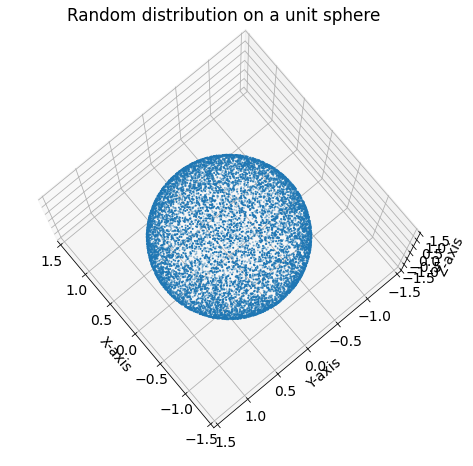

In [7]:
def generate_unit_sphere(num_vectors):
    # Generate random polar and azimuthal angles
    theta = np.arccos(2 * np.random.uniform(size=num_vectors) - 1)  # polar angle
    phi = 2 * np.pi * np.random.uniform(size=num_vectors)  # azimuthal angle

    # Create a result array
    vectors = np.empty((num_vectors, 3), dtype=np.float64)

    # Calculate sin(theta) once to avoid redundant calculations
    sin_theta = np.sin(theta)

    # Convert spherical polar coordinates to Cartesian coordinates and store them in the result array
    vectors[:, 0] = sin_theta * np.cos(phi)
    vectors[:, 1] = sin_theta * np.sin(phi)
    vectors[:, 2] = np.cos(theta)

    return vectors


# Generate a random 3D dataset with SAMPLE_SIZE samples
vectors = generate_unit_sphere(SAMPLE_SIZE)

# Plot the dataset in a 3D scatter plot
plot_3d_scatter(vectors[:,0], vectors[:,1], vectors[:,2], "Random distribution on a unit sphere")

The above plot demonstrates the generation of isotropic unit vectors. It is important to note that the use of `np.random.uniform` has ensured there are no poles on the sphere.

#### Isotropic exponential distribution

Next we will multiply the points on the isotropic unit sphere by an exponential value to create an isotropic exponential distribution, where the distribution is given by $e^{-\frac{x}{\lambda}}.$

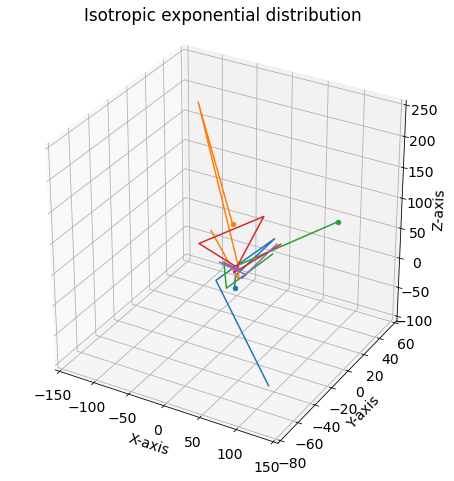

In [8]:
def gen_exponential_steps(num_steps, mean_free_path):
    # Generate random step lengths with exponential distribution
    step_lengths = gen_exponential_dataset(num_steps, mean_free_path)

    # Generate random unit vectors using spherical polar coordinates
    unit_vectors = generate_unit_sphere(num_steps)

    # Scale the unit vectors by the step lengths to get the step displacements
    steps = unit_vectors * step_lengths[:, np.newaxis]
    return steps


def plot_3d_scatter_with_lines(num_simulations, num_steps, material):
    # Calculate the mean free path for absorption for the given material
    mean_free_path = mean_free_path_absorption(material)

    # Generate the specified number of simulations, each with the given number of steps
    simulations = [gen_exponential_steps(num_steps, mean_free_path) for _ in range(num_simulations)]

    # Create a 3D scatter plot with lines connecting the points
    fig = plt.figure(figsize=(12, 6))
    ax = Axes3D(fig)

    # Loop through the simulations
    for simulation in simulations:
        x, y, z = simulation[:,0], simulation[:,1], simulation[:,2]

        # Plot the final positions as dots
        ax.scatter(x[-1], y[-1], z[-1])

        # Plot lines between the points
        ax.plot(x, y, z)

    # Configure plot settings
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_zlabel("Z-axis")
    ax.set_box_aspect(aspect=(1, 1, 1))
    ax.set_title("Isotropic exponential distribution")

    # Display the plot
    plt.show()


plot_3d_scatter_with_lines(5, 5, 'Water')

## Investigation - Neutron Transport and Scattering Through a Shielding Layer

We will simulate the behaviour of thermal neutrons as they travel through water, lead, and graphite under various conditions. Thermal neutrons are defined as free neutrons that are not bound to any atom and possess kinetic energy equal to the average kinetic energy of their environment.

We will determine the macroscopic absorption and scattering cross-sections, as well as the total mean free path ($\lambda$), for each material. We will visualize the random walk of a few neutrons through each material and calculate the absorption, reflection, and transmission rates for a large number of neutrons.

We will then investigate the variation in neutron transmission, reflection, and absorption rates with slab thickness for the three materials and determine their characteristic attenuation lengths and estimated errors. Finally, as a bonus task, we will implement the Woodcock method to calculate the fraction of neutrons transmitted through two slabs of different materials in contact with each other.

We begin by defining the thickness of the slab will be simulating the neutrons travelling through.

In [9]:
# Choose the default slab thickness in cm
SLAB_THICKNESS = 10 

# Initialise an array of slab thickness in cm
MIN_SLAB_THICKNESS = 1
MAX_SLAB_THICKNESS = 20
SLAB_THICKNESSES = np.geomspace(MIN_SLAB_THICKNESS, MAX_SLAB_THICKNESS, MAX_SLAB_THICKNESS)

Next, we will implement the code to calculate the probability of absorption and the mean free path for each material. The equations here are similar to the case examined above for the characteristic attenuation length of water however we are now also considering scattering.

In [10]:
def neutron_calculations(material):
    if material == "Vacuum":
        # return the absorption probability as zero 
        # and the mean free path as 1e8 cm (>> 10 cm) which is used as an approximate for infinity 
        return 0, 1e8

    else:
        # Calculate absorption cross section for given material
        absorption_cross_section_macro = (densities[material] * absorption_cross_sections[material] 
                                          / molar_masses[material] * AVOGADRO)

        # Calculate scattering cross section for given material
        scattering_cross_section_macro = (densities[material] * scattering_cross_sections[material]
                                          / molar_masses[material] * AVOGADRO)

        # Calculate total cross section
        total_cross_section = absorption_cross_section_macro + scattering_cross_section_macro

        # Calculate absorption probability
        absorption_probability = absorption_cross_section_macro / total_cross_section

        # Calculate mean free path
        mean_free_path = 1 / total_cross_section

    return absorption_probability, mean_free_path

We will now introduced the `simulate_neutron` function, which simulates the behaviour of thermal neutrons as they interact with a material in a slab of specified thickness. It takes as input the material properties, slab thickness, the number of neutrons to simulate, and a flag indicating whether to save the positions of the neutrons during the simulation. The function returns either the neutron counts in various states (absorbed, reflected, transmitted) or the paths of all simulated neutrons, depending on the value of the `save_paths` flag.

The function follows the following logic:

1. The `neutron_calculations` function calculates the absorption probability and mean free path based on the input material.

2. The `initialise_neutron_simulation` function initialises the positions, directions, and counters for absorbed, reflected, and transmitted neutrons. The neutrons will begin at $(x,y,z)=(0,0,0)$ and move straight into the medium by taking their first step in the positive $x$ direction.

3. If the `save_paths` flag is set to True, the function initialises a list `positions_all` to store the positions of all neutrons during the simulation, and an array `indices_remaining` to keep track of the remaining neutrons.

4. The main loop of the function simulates the behaviour of the remaining neutrons. This loop continues until there are no remaining neutrons to simulate.

   a. The `gen_exponential_dataset` function generates a dataset of steps for each neutron based on the mean free path of the material.

   b. The new positions of the neutrons are calculated by adding the steps (distributed by $e^{-\frac{x}{\lambda}}$) multiplied by their respective directions to their current positions.

   c. If the `save_paths` flag is set to True, the function saves the updated positions for each neutron to the `positions_all` list.

   d. The `calculate_neutron_indices` function finds the indices of neutrons that are reflected, transmitted, absorbed, or outside the slab.

   e. The function updates the counters for absorbed, reflected, and transmitted neutrons based on the indices calculated in the previous step.

   f. The `update_neutron_data` function updates the positions, directions, and the number of remaining neutrons based on the neutron indices.

   g. If the `save_paths` flag is set to True, the function updates the `indices_remaining` array based on the remaining neutrons.


5. If the `save_paths` flag is set to True, the function returns the `positions_all` list containing the paths of all simulated neutrons. Otherwise, it returns the counts of absorbed, reflected, and transmitted neutrons.

In [11]:
def initialise_neutron_simulation(n_neutrons):
    # Create an array of zeros for neutron positions
    positions = np.zeros((n_neutrons, 3))

    # Create an array of directions for each neutron, all initially along x-axis
    directions = np.tile(np.array([1.0, 0.0, 0.0]), (n_neutrons, 1))

    # Initialise counters for absorbed, reflected, and transmitted neutrons
    n_absorbed, n_reflected, n_transmitted = 0, 0, 0

    return positions, directions, n_absorbed, n_reflected, n_transmitted


def calculate_neutron_indices(positions_update, slab_thickness, n_neutrons, absorption_prob):
    # Find indices of neutrons that are reflected (negative x-coordinate)
    indices_reflected = positions_update[:, 0] < 0

    # Find indices of neutrons that are transmitted (x-coordinate > slab thickness)
    indices_transmitted = positions_update[:, 0] > slab_thickness

    # Find indices of neutrons that are outside the slab (either reflected or transmitted)
    indices_outside = indices_reflected | indices_transmitted

    # Find indices of neutrons that are absorbed (random probability)
    indices_absorbed = np.random.uniform(size=n_neutrons) < absorption_prob
    
    return indices_reflected, indices_transmitted, indices_absorbed, indices_outside


def update_neutron_data(positions_update, directions, indices_absorbed, indices_outside, save_paths):
    # Create a boolean array for neutrons that are neither absorbed nor outside
    n_remaining = ~(indices_absorbed | indices_outside)

    # Update positions of the remaining neutrons
    positions = positions_update[n_remaining]

    # Update directions of the remaining neutrons
    directions = directions[n_remaining]

    # Update the number of neutrons
    n_neutrons = positions.shape[0]
    
    # Generate random directions on the unit sphere for the remaining neutrons
    directions = generate_unit_sphere(n_neutrons)
    
    return positions, directions, n_neutrons, n_remaining


def simulate_neutron(material, slab_thickness, n_neutrons, save_paths=False):
    # Calculate material properties
    absorption_probability, mean_free_path = neutron_calculations(material)

    # Initialise neutron positions, directions and counters
    positions, directions, n_absorbed, n_reflected, n_transmitted = initialise_neutron_simulation(n_neutrons)

    # Initialise lists to save positions if required
    if save_paths:
        positions_all = [[] for _ in range(n_neutrons)]
        indices_remaining = np.arange(n_neutrons)

    # Simulate n_neutrons
    while n_neutrons > 0:
        # Calculate steps based on mean free path
        steps = gen_exponential_dataset(n_neutrons, mean_free_path)
        positions_update = positions + steps[:, np.newaxis] * directions

        # Save positions if required (note that the .append is rarely called and so hardly impacts efficiency)
        if save_paths:
            for i, pos in enumerate(positions_update):
                positions_all[indices_remaining[i]].append(pos)

        # Check if neutrons are reflected, transmitted, or absorbed
        indices_reflected, indices_transmitted, indices_absorbed, indices_outside = calculate_neutron_indices(
            positions_update, slab_thickness, n_neutrons, absorption_probability)

        # Update counters
        n_reflected += np.sum(indices_reflected)
        n_transmitted += np.sum(indices_transmitted)
        n_absorbed += np.sum(indices_absorbed & ~indices_outside)

        # Update neutron data
        positions, directions, n_neutrons, n_remaining = update_neutron_data(
            positions_update, directions, indices_absorbed, indices_outside, save_paths)

        # Update indices_remaining if required
        if save_paths:
            indices_remaining = indices_remaining[n_remaining]

    if save_paths:
        positions_all = [np.vstack((np.zeros(3), path)) for path in positions_all]
        return positions_all
    else:
        return n_absorbed, n_reflected, n_transmitted

### Plot of several neutron paths

To demonstrate that the simulation is visually working we will show the path of a few neutrons through each material. 

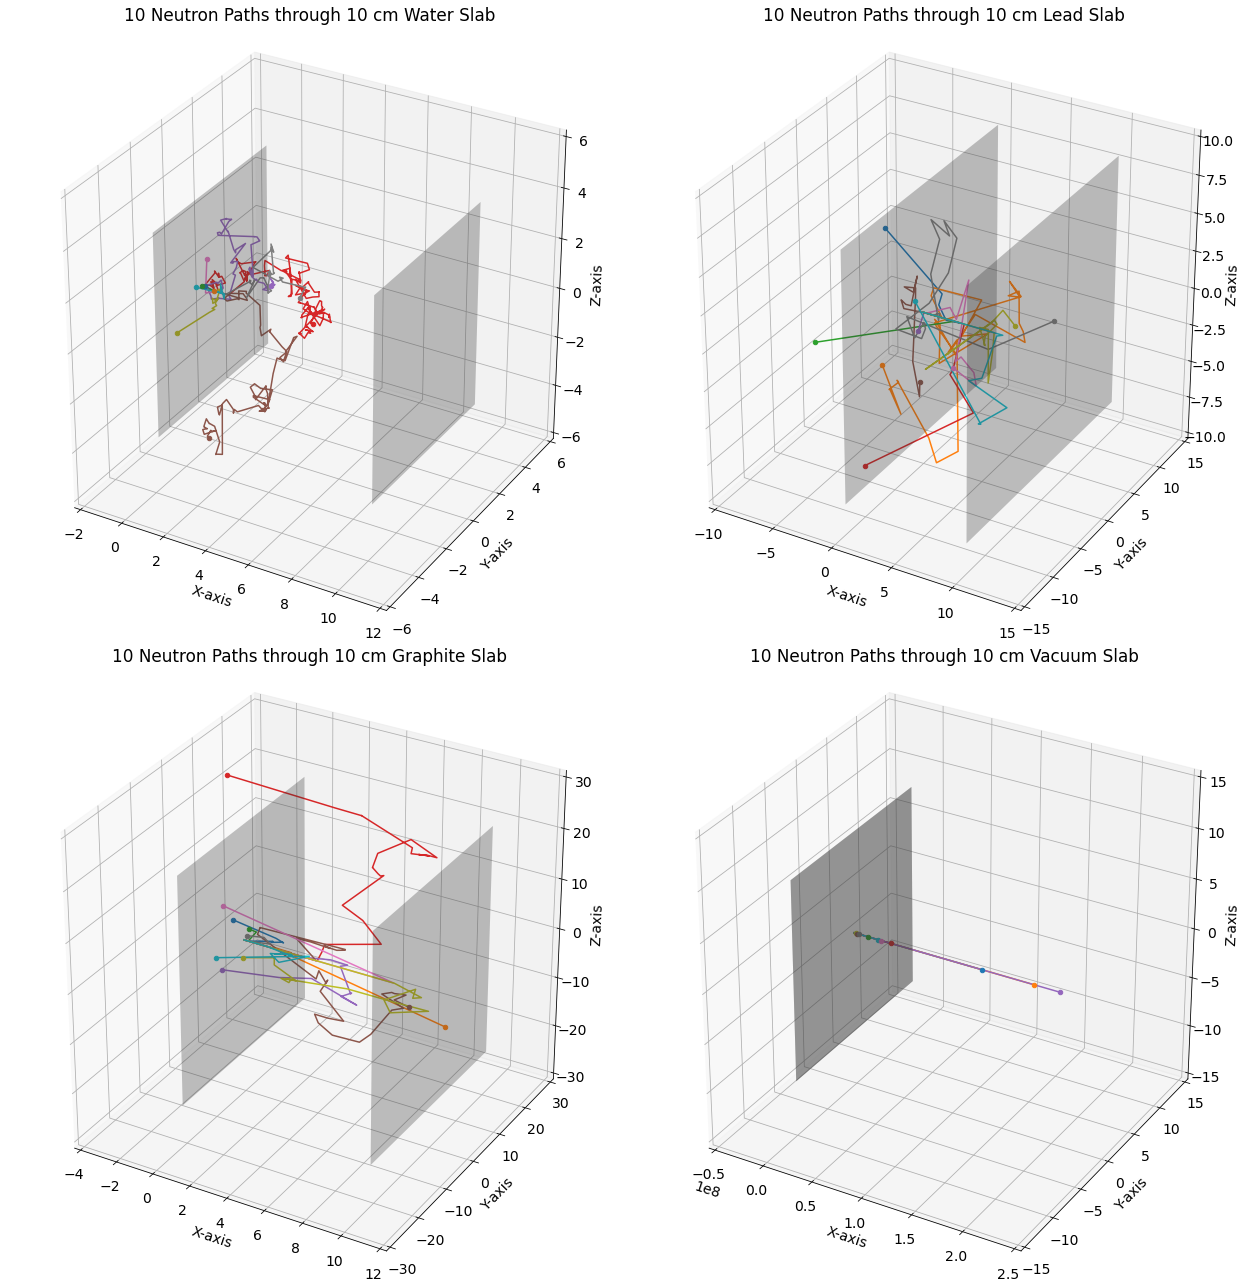

In [12]:
def plot_simulation(slab_thickness, neutron_number):
    # Create 3D plot
    fig = plt.figure(figsize=(18, 18))
    
    for k, material in enumerate(materials):
        
        ax = fig.add_subplot(2, 2, k+1, projection='3d')
    
        # Simulate neutrons and save their positions
        neutron_paths = simulate_neutron(material, slab_thickness, neutron_number, save_paths=True)

        # Initialise maximum y and z displacements
        max_y = 0
        max_z = 0

        # Plot neutron paths and find maximum y and z displacements (if they are zero then set them to 10)
        for path in neutron_paths:
            path = np.array(path)
            ax.scatter(path[-1, 0], path[-1, 1], path[-1, 2], marker="o")
            ax.plot(path[:, 0], path[:, 1], path[:, 2], '-')

            max_y = max(max_y, np.max(np.abs(path[:, 1])))
            max_z = max(max_z, np.max(np.abs(path[:, 2])))
            
            if max_y == 0:
                max_y = max_z = 10

        # Create arrays for y and z coordinates of the planes
        y, z = np.meshgrid([-max_y, max_y], [-max_z, max_z])

        # Create arrays for x coordinates of the planes
        x_front_of_slab = np.zeros_like(y)
        x_back_of_slab = np.full_like(y, slab_thickness)

        # Plot the two planes
        ax.plot_surface(x_front_of_slab, y, z, alpha=0.3, color='gray')
        ax.plot_surface(x_back_of_slab, y, z, alpha=0.3, color='gray')

        # Configure plot settings
        ax.set_xlabel("X-axis")
        ax.set_ylabel("Y-axis")
        ax.set_zlabel("Z-axis")
        ax.set_title(f"{neutron_number} Neutron Paths through {slab_thickness} cm {material} Slab")
        ax.set_box_aspect(aspect=(1, 1, 1))

    # Display the plot
    plt.tight_layout()
    plt.show()


plot_simulation(SLAB_THICKNESS, 10)

The above plot shows the path of 10 neutrons through 10 cm slabs of each material, showing the slab edges as two grey rectangles. The plot demonstrates the effect of scattering and absorption on the reflection and transmission rates of neutrons. Note that the final positions of the neutrons are represented by dots, and the paths they took to get there are shown by lines.

Owing to water's very high scattering cross section and high absorption cross section, as well as its density and molar mass, we expect neutrons in water to scatter many times with a short mean free path, with very few neutrons being transmitted. This prediction is observed. 

For neutrons in lead and graphite we expect them to have similar rates of reasonably high transmission, with lead absorbing slightly more neutrons and thus reflecting fewer than graphite. Again, this prediction can be seen in the above plots. 

Finally, in a vacuum, all the thermal neutrons are transmitted and no scattering takes place. It should be noted that the simulation approximates the infinite mean free path in a vacuum as being 1e8 cm (>> 10 cm). This is to allow for the calculations to execute without errors.

### Absorption, reflection and transmission rates by material

We expect similar trends to the predictions in the above plots; however, the increased number of thermal neutrons being simulated (ten thousand) and the repetition of the simulation (ten times) means that the trends seen should be statistically significant.

In [13]:
def calculate_mean_rates(material, slab_thickness, n_neutrons, n_trials):
    # Define the names of the rates and initialise arrays to store mean rates and mean errors
    n_rate_types = 3
    rates = np.zeros((n_trials, n_rate_types))

    # Perform multiple trials for each rate
    for j in range(n_trials):
        # Simulate neutron interaction and get the rate values
        rates[j] = simulate_neutron(material, slab_thickness, n_neutrons)

    # Calculate the mean rate and error for each rate name
    mean_rates = np.mean(rates, axis=0)
    mean_errors = np.std(rates, axis=0)

    # Calculate the total mean rate and convert rates and errors to percentages
    total_mean_rate = np.sum(mean_rates)
    mean_rates_percent = mean_rates / total_mean_rate * 100
    mean_errors_percent = mean_errors / total_mean_rate * 100

    return mean_rates_percent, mean_errors_percent


def tabulate_simulation(slab_thickness, n_neutrons, n_trials):
    # Initialise a list to store the results
    results = []

    # Loop through the materials
    for material in materials:

        # Calculate the mean rates and errors for each material
        mean_rates_percent, mean_errors_percent = calculate_mean_rates(
            material, slab_thickness, n_neutrons, n_trials)

        # Perform neutron calculations and get the mean free path
        _, mean_free_path = neutron_calculations(material)
        
        if material == "Vacuum":
            mean_free_path = float('inf')

        # Format the results and append to the list
        formatted_results = [f"{mean_rates_percent[1]:.2f} ± {mean_errors_percent[1]:.2f}",
                            f"{mean_rates_percent[0]:.2f} ± {mean_errors_percent[0]:.2f}",
                            f"{mean_rates_percent[2]:.2f} ± {mean_errors_percent[2]:.2f}",
                            f"{mean_free_path:.3f}"]

        results.append(formatted_results)

    # Create a DataFrame with the results and display it
    df = pd.DataFrame(results, columns=['Reflection (%)', 'Absorption (%)', 
                                        'Transmission (%)', f'$\lambda$ (cm)'], index=materials)
    display(df)


# Create a table to show the results of the simulation for all materials (using 10,000 neutrons repeated 10 times)
tabulate_simulation(SLAB_THICKNESS, SAMPLE_SIZE, N_REPEATS)

Reflection (%) Absorption (%) Transmission (%) $\lambda$ (cm)
Water      79.72 ± 0.43   19.96 ± 0.42      0.32 ± 0.05          0.289
Lead       61.97 ± 0.58   10.04 ± 0.33     27.99 ± 0.36          2.664
Graphite   68.25 ± 0.47    0.86 ± 0.07     30.89 ± 0.48          2.517
Vacuum      0.00 ± 0.00    0.00 ± 0.00    100.00 ± 0.00            inf

Water: A high absorption rate due to the high probability of absorption. Almost all neutrons that are not absorbed are reflected out of the slab, resulting in very a low transmission rate due to the short mean free path.

Lead: A lower absorption and reflection rate than water, with more neutrons being transmitted due to the longer mean free path and smaller absorption probability.

Graphite: A similar transmission rate to lead owing to the neutrons having a similar mean free path. However, unlike lead, there is almost zero absorption. This is due to the absorption probability being very low.  This results in a higher reflection rate than lead by about ten percent.

Vacuum: All neutrons are transmitted, as the mean free path is infinite and the absorption probability is zero.  Note that in reality the mean free path is actually set to 1e8 cm but this can be approximated as infinite since the slab is only 10 cm thick.

Overall, these results are in line with the predictions we made when plotting the neutron paths through each material.

### Investigating slab thickness & characteristic attenuation length

Next, we will run the thermal neutron simulation whilst varying the thickness of the slab it is moving through. This should impact the proportion of neutrons which are transmitted as we expect that with increasing thicknesses fewer neutrons will be transmitted. 

To investigate the impact of slab thickness, plots of the ratios of transmitted, absorbed, and reflected neutrons against a range of exponentially distributed thicknesses for the three different materials will be displayed. As above, the simulation will be repeated ten times for ten thousand neutrons for each data point. 

Finally, we will use the mean transmission rate values to find the attenuation depth of each medium. The data will be linearised and fitted to the following equation, derived from the Beer–Lambert law:

$$N=N_0 e^{-\frac{T}{\lambda}}$$

where $T$ is the thickness of the slab, $N_{0}$ is the total number of neutrons going into the sample and $N$ is the number of particles absorbed. From this we can find the attenuation depth of each material, $\lambda$. 

The attenuation length is a measure of how effectively a material can reduce the intensity of radiation (such as electromagnetic waves or particles) as it passes through the material. It is defined as the distance over which the intensity of the radiation decreases to 1/e (approximately 36.8%) of its initial value. A larger attenuation length indicates that the material is less effective at stopping or attenuating the radiation, as it takes a greater distance for the radiation to be significantly reduced. Conversely, a smaller attenuation length means that the material is more effective at attenuating radiation, as it takes a shorter distance for the radiation intensity to be reduced.

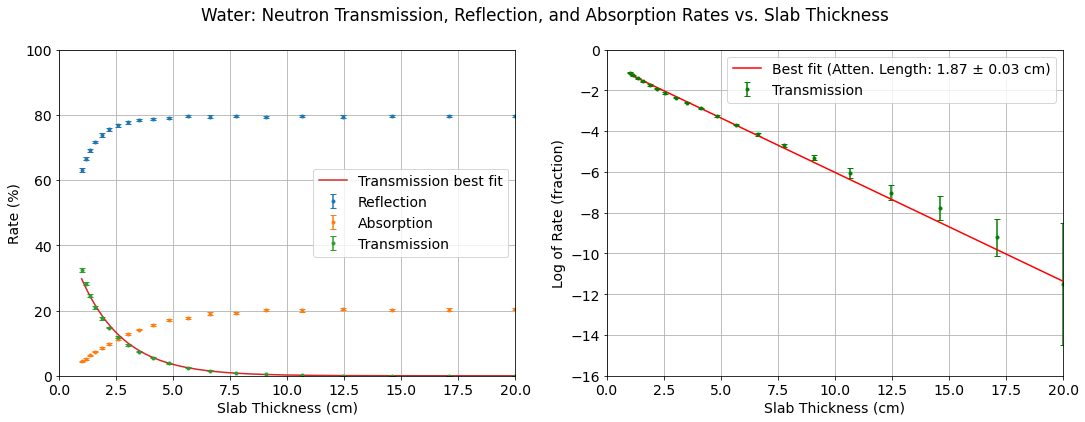

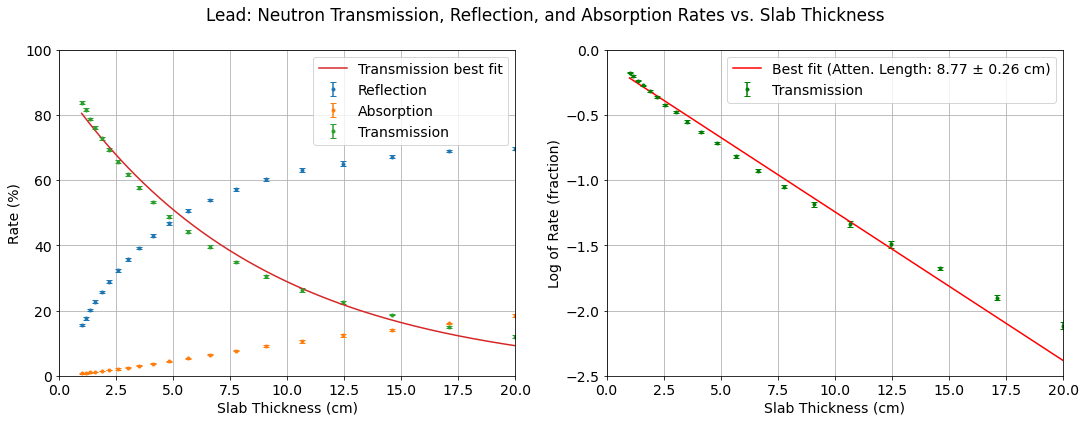

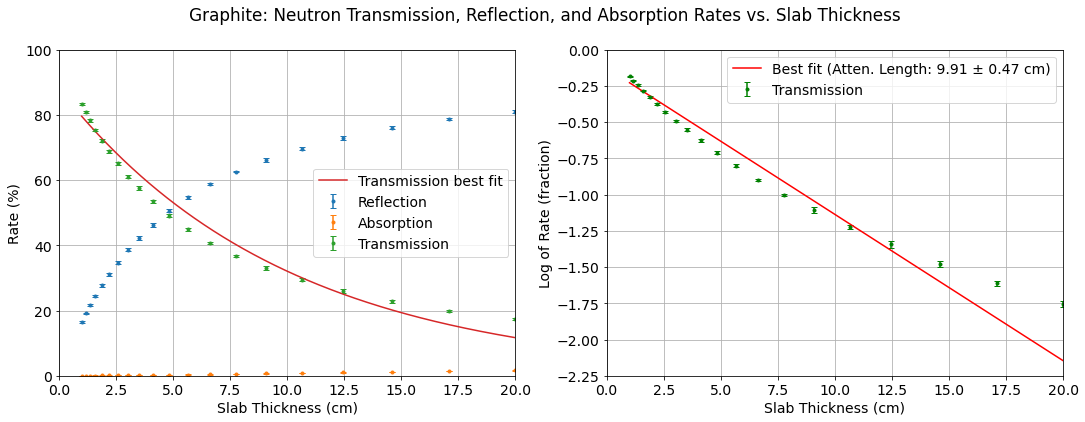

In [14]:
def collect_material_data(material, slab_thicknesses, n_neutrons, n_trials):
    progress_bar = False
    n_thicknesses = len(slab_thicknesses)
    
    # Initialise arrays to store the material values and errors
    material_values_percent = np.zeros((n_thicknesses, 3))
    material_errors_percent = np.zeros((n_thicknesses, 3))
    
    # Loop through the different slab thicknesses
    for i, thickness_value in tqdm(enumerate(slab_thicknesses), 
                                   desc="Progress", disable=progress_bar, total=n_thicknesses):

        # Calculate the mean rates and errors for each slab thickness
        mean_rates_percent, mean_errors_percent = calculate_mean_rates(material, thickness_value, 
                                                                       n_neutrons, n_trials)

        # Store the calculated values and errors in their respective arrays
        material_values_percent[i] = mean_rates_percent
        material_errors_percent[i] = mean_errors_percent

    return material_values_percent, material_errors_percent


def filter_and_log_values(values, errors, slab_thicknesses):
    # Filter the values, errors, and slab thicknesses based on the nonzero values
    non_zero_values = values[values > 0]
    non_zero_errors = errors[values > 0]
    non_zero_slab_thicknesses = slab_thicknesses[values > 0]
    
    # Calculate the log of the nonzero values and the corresponding errors
    log_values = np.log(non_zero_values)
    log_errors = non_zero_errors / non_zero_values
    return log_values, log_errors, non_zero_slab_thicknesses


def fit(transmission_values, transmission_errors, slab_thicknesses):
    # Filter and log the transmission values, errors, and slab thicknesses
    log_values, log_errors, non_zero_slab_thicknesses = filter_and_log_values(
        transmission_values, transmission_errors, slab_thicknesses)
    
    # Perform a weighted linear fit and return the fit parameters and covariance matrix
    popt, pcov = np.polyfit(non_zero_slab_thicknesses, log_values, 1, w=1/log_errors, cov=True)

    # Calculate the standard errors for the fit parameters
    perr = np.sqrt(np.diag(pcov))
    return popt, perr


def linear_plot(ax2, slab_thicknesses, popt, perr, transmission_values, transmission_errors, material):
    # Filter and log the transmission values, errors, and slab thicknesses
    log_values, log_errors, non_zero_slab_thicknesses = filter_and_log_values(
        transmission_values, transmission_errors, slab_thicknesses)

    # Plot the data points with error bars
    ax2.errorbar(non_zero_slab_thicknesses, log_values, yerr=log_errors, fmt='g.', capsize=3, 
                 label=f"Transmission")

    # Calculate the attenuation length and its uncertainty
    atten_length = - 1 / popt[0]
    atten_length_uncertainty = perr[0] * atten_length ** 2

    # Plot the best-fit line
    y = np.polyval(popt, non_zero_slab_thicknesses)
    ax2.plot(non_zero_slab_thicknesses, y, "r",
            label=f"Best fit (Atten. Length: {atten_length:.2f} ± {atten_length_uncertainty:.2f} cm)")
    
    # Configure plot settings
    ax2.set_xlabel("Slab Thickness (cm)")
    ax2.set_ylabel("Log of Rate (fraction)")
    plt.rcParams['axes.autolimit_mode'] = 'round_numbers'
    ax2.set_xlim(0, MAX_SLAB_THICKNESS)
    ax2.legend()
    ax2.grid()


def plot_material_data(material, slab_thicknesses, n_neutrons, n_trials):
    # Collect material data (values and errors) for given slab thicknesses
    values_percent, errors_percent = collect_material_data(material, slab_thicknesses, n_neutrons, n_trials)

    # Plot absorption, reflection and transmission data with error bars
    plt.rcParams.update({'font.size': 14}) # Set the text size to 14
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    fig.suptitle(f"{material}: Neutron Transmission, Reflection, and Absorption Rates vs. Slab Thickness")
    
    ax1.errorbar(slab_thicknesses, values_percent[:, 1], yerr=errors_percent[:, 1], fmt='.', 
                label=f"Reflection", capsize=3)
    ax1.errorbar(slab_thicknesses, values_percent[:, 0], yerr=errors_percent[:, 0], fmt='.', 
                label=f"Absorption", capsize=3)
    ax1.errorbar(slab_thicknesses, values_percent[:, 2], yerr=errors_percent[:, 2], fmt='.',
                label=f"Transmission", capsize=3)

    # Convert the values and errors from percentage to fractions
    values_fraction = values_percent / 100
    errors_fraction = errors_percent / 100

    # Fit the transmission values to an exponential model
    popt, perr = fit(values_fraction[:, 2], errors_fraction[:, 2], slab_thicknesses)
    
    # Generate x values for the best-fit line and calculate the line
    x = np.linspace(MIN_SLAB_THICKNESS, MAX_SLAB_THICKNESS, 1000)
    fit_line = np.exp(np.polyval(popt, x))

    # Plot the linear plot for the transmission values
    linear_plot(ax2, slab_thicknesses, popt, perr, values_fraction[:, 2], errors_fraction[:, 2], material)
    
    # Calculate the attenuation length and its uncertainty
    atten_length = - 1 / popt[0]
    atten_length_uncertainty = perr[0] * atten_length**2

    # Plot the best-fit line for the transmission values
    ax1.plot(x, fit_line * 100, 
            label=f"Transmission best fit")
    
    # Configure plot settings
    ax1.set_xlabel("Slab Thickness (cm)")
    ax1.set_ylabel("Rate (%)")
    ax1.set_ylim(0, 100)
    ax1.set_xlim(0, MAX_SLAB_THICKNESS)
    ax1.legend()
    ax1.grid()

    # Display the plot
    plt.show()


# Create plots of neutron transmission, reflection, and absorption rates vs. slab thickness for each material
plot_material_data('Water', SLAB_THICKNESSES, SAMPLE_SIZE, N_REPEATS)
plot_material_data('Lead', SLAB_THICKNESSES, SAMPLE_SIZE, N_REPEATS)
plot_material_data('Graphite', SLAB_THICKNESSES, SAMPLE_SIZE, N_REPEATS)

The plots show the transmission rates decreasing with increased slab thickness, while the absorption and reflection rates increase as expected.  The calculated attenuation lengths (when repeated one hundred times instead of just ten) are 1.84 ± 0.04 cm for water, 8.7 ± 0.3 cm for lead and 10.1 ± 0.5 cm for graphite. These values are consistent with what was expected as the transmission rate for water is the lowest and the transmission rate for graphite is the highest. It should be noted that the goodness of fit for the lead and the graphite in particular is poor, implying that the simulation and the theory predicted different trends in the data, to investigate this further different simulation techniques should be tested.

Water has the shortest attenuation, which demonstrates that water is the best radiation shield, particularly for high-energy radiation like gamma rays and neutrons. This is because its high hydrogen content makes it effective at slowing down and capturing neutrons, while its oxygen content and density help attenuate gamma rays. 

However, it is essential to consider other factors such as the specific type of radiation to be shielded and practical aspects (such as weight, cost, and ease of use) when selecting the best shielding material for a given application.  For example water needs to be contained in an appropriate structure or vessel, which may add complexity, weight, and cost to the shielding system, and the risk of evaporation and leakage is also a significant consideration which doesn't impact lead or graphite. 

Hence although water has the best shielding capabilities, the above factors mean it is not as widely used as lead and graphite. Lead is widely available and thus cheap, but its weight and toxicity make using it more complicated. Graphite is very light by comparison, however its more expensive and has the longest attenuation coefficient.

Overall, it is evident that a wide range of factors beyond just the attenuation length need to be considered when choosing a shielding material.

In [15]:
# End the execution timer and output the time taken
END_TIME = time.time()
RUN_TIME = END_TIME - START_TIME

print(f"Runtime: {RUN_TIME:.0f} seconds")

Runtime: 32 seconds


The code consistently runs in significantly under one minute, usually only taking around 40 seconds (depending on the dpi of the animated histogram and how well the Jupyter severs are doing).

## Neutron Simulation for Two Adjacent Slabs

Previously, we examined single-material scenarios, which required us to work with only one value of lambda. Unfortunately, this approach is not suitable for neutrons scattered through various media, each with different lambda values. To address this, we will now explore the case of two slabs composed of different materials in contact with each other.

#### EGS Sampling

The Electron Gamma Sampling (EGS) method is used to generate samples. First, we compute the probability distribution for each process (absorption or scattering) using the calculated mean free path:

$$P[x_{a}]=e^{-x/\lambda_{a}}, P[x_{s}]=e^{-x/\lambda_{s}}$$

Instead of generating a single step size $s_{i}$, we generate two step sizes: $s_{a}=-\lambda_{a}log(u_{i})$ and $s_{s}=-\lambda_{s}log(u_{i})$. From these, we choose the shortest distance to determine which process (absorption or scattering) takes place: $s_{i}=min[s_{a},s_{s}]$. However, this method produces biased steps when a neutron transitions to a different medium. To account for this, the program must identify the appropriate mean free path and calculate it for each cross-section. To eliminate this bias, we employ the Woodcock Tracking method.

#### Woodcock Method

In the Woodcock method, we select the majorant cross-section, $\Sigma_{T}=max(\Sigma_{1},\Sigma_{2})$, and base our steps on this value. However, not all steps will lead to one of the previously considered processes when a neutron is inside a medium with a longer mean free path (mfp). To account for the advantage introduced by using the shorter lambda, some steps will be "fictitious," meaning they lead to neither scattering nor absorption.

Fictitious steps occur when the macroscopic cross-section of a medium, $\Sigma_{1}$, results in a probability smaller than a randomly generated number. The probability of a fictitious step can be calculated as follows:

$$P[f]=\frac{\Sigma_{f}}{\Sigma_{T}}=\frac{\Sigma_{T}-\Sigma_{1}}{\Sigma_{T}}=1-\frac{\Sigma_{1}}{\Sigma_{T}}$$

A step is considered "real" if the probability of a process, $P[1]=\frac{\Sigma_{1}}{\Sigma_{T}}$, is greater than the threshold value $v$. Once it is determined that the step is real, we must decide which process (absorption or scattering) occurs. This decision is based on the macroscopic cross-sections of the two processes. If a random number $u$ is smaller than the probability of one process (e.g., absorption), the other process (scattering) occurs.

In [16]:
def update_directions_woodcock(positions, directions, n_neutrons, slab_thickness1, total_cross_section1, total_cross_section2):
    # Determine if each neutron is in material 1 (True) or material 2 (False)
    in_material1 = positions[:, 0] <= slab_thickness1

    # Calculate the probability of a fictitious collision for each neutron
    probability_fictitious = 1 - (np.where(in_material1, total_cross_section1, total_cross_section2)
                                  / max(total_cross_section1, total_cross_section2))

    # Find the indices of neutrons with fictitious collisions
    indices_fictitious = np.random.uniform(size=n_neutrons) < probability_fictitious

    # Find the indices of neutrons with real collisions
    indices_real = ~indices_fictitious

    # Update the directions of neutrons with real collisions
    directions[indices_real] = generate_unit_sphere(np.sum(indices_real))

    # For neutrons with fictitious collisions, the directions remain unchanged, so no update is needed

    return directions


def neutron_simulation_woodcock(material1, material2, slab_thickness1, slab_thickness2, n_neutrons):
    # Calculate absorption probability and mean free path for each material
    absorption_probability1, mean_free_path1 = neutron_calculations(material1)
    absorption_probability2, mean_free_path2 = neutron_calculations(material2)

    # Calculate total cross section for each material and find the maximum of the two
    total_cross_section1 = 1 / mean_free_path1
    total_cross_section2 = 1 / mean_free_path2
    max_cross_section = max(total_cross_section1, total_cross_section2)

    # Calculate the mean free path of the fictitious material
    mean_free_path_fictitious = 1 / max_cross_section

    # Initialise neutron positions, directions and counters
    positions, directions, n_absorbed, n_reflected, n_transmitted = initialise_neutron_simulation(n_neutrons)

    # Loop until no neutrons are left
    while n_neutrons > 0:
        # Calculate proposed positions for neutrons after taking steps
        steps = gen_exponential_dataset(n_neutrons, mean_free_path_fictitious)
        positions_update = positions + steps[:, np.newaxis] * directions

        # Determine indices of neutrons that are reflected or transmitted
        indices_reflected = positions_update[:, 0] < 0
        indices_transmitted = positions_update[:, 0] > (slab_thickness1 + slab_thickness2)
        indices_outside = indices_reflected | indices_transmitted

        # Calculate absorption probabilities for neutrons depending on their positions
        absorption_probabilities = np.where(positions_update[:, 0] <= 
                                            slab_thickness1, absorption_probability1, absorption_probability2)
        indices_absorbed = np.random.uniform(size=n_neutrons) < absorption_probabilities

        # Update counters for absorbed, reflected, and transmitted neutrons
        n_reflected += np.sum(indices_reflected)
        n_transmitted += np.sum(indices_transmitted)
        n_absorbed += np.sum(indices_absorbed & ~indices_outside)

        # Determine indices of neutrons that are still inside the slabs
        indices_remaining = ~(indices_absorbed | indices_outside)
        positions = positions_update[indices_remaining]
        directions = directions[indices_remaining]
        n_neutrons = positions.shape[0]

        # Update directions for the remaining neutrons
        directions = update_directions_woodcock(positions, directions, n_neutrons, slab_thickness1, 
                                                total_cross_section1, total_cross_section2)

    return n_absorbed, n_reflected, n_transmitted


def calculate_mean_rates_woodcock(material1, material2, slab_thickness1, slab_thickness2, n_neutrons, n_trials):
    # Define rate names for absorption, reflection, and transmission
    rate_names = ['absorption', 'reflection', 'transmission']

    # Initialise arrays for mean rates and their errors
    mean_rates = np.zeros(3)
    mean_errors = np.zeros(3)

    # Loop through rate types (absorption, reflection, transmission)
    for i, rate_name in enumerate(rate_names):
        rates = np.zeros(n_trials)
        # Perform n_trials simulations for each rate type
        for j in range(n_trials):
            rate = neutron_simulation_woodcock(material1, material2, slab_thickness1, slab_thickness2, n_neutrons)
            rates[j] = rate[i]

        # Calculate mean rate and its error (standard deviation) for each rate type
        mean_rates[i] = np.mean(rates)
        mean_errors[i] = np.std(rates)

    # Calculate the total mean rate and convert mean rates and errors to percentages
    total_mean_rate = np.sum(mean_rates)
    mean_rates_percent = mean_rates / total_mean_rate * 100
    mean_errors_percent = mean_errors / total_mean_rate * 100

    # Print the results
    print(f'Material 1: {slab_thickness1} cm thick {material1}\n'
          f'Material 2: {slab_thickness2} cm thick {material2}\n')

    print(f'Reflection: ({mean_rates_percent[1]:.2f} ± {mean_errors_percent[1]:.2f})%\n'
          f'Absorption: ({mean_rates_percent[0]:.2f} ± {mean_errors_percent[0]:.2f})%\n'
          f'Transmission: ({mean_rates_percent[2]:.2f} ± {mean_errors_percent[2]:.2f})%')


# Woodcock method with 10 cm thick Vacuum and 10 cm thick Graphite
calculate_mean_rates_woodcock('Vacuum', 'Graphite', 10, 10, SAMPLE_SIZE, N_REPEATS)

Material 1: 10 cm thick Vacuum
Material 2: 10 cm thick Graphite

Reflection: (68.22 ± 0.46)%
Absorption: (0.84 ± 0.06)%
Transmission: (30.94 ± 0.53)%


The above output shows the results of a woodcock method neutron simulation for neutrons propagating through a 10 cm thick vacuum slab followed by a 10 cm thick graphite slab. We would expect the results to be identical to those for just a 10 cm graphite slab (69% reflection, 1% absorption, 30% transmission) and this is indeed the case, showing that the woodcock method is working as intended.

In [17]:
# Woodcock method with 5 cm thick Lead and 5 cm thick Lead
calculate_mean_rates_woodcock('Lead', 'Lead', 5, 5, SAMPLE_SIZE, N_REPEATS)

Material 1: 5 cm thick Lead
Material 2: 5 cm thick Lead

Reflection: (61.86 ± 0.35)%
Absorption: (10.11 ± 0.19)%
Transmission: (28.03 ± 0.35)%


Now we have adjusted the slabs so that the neutrons go through two 5 cm slabs of lead. Evidently this should give the same results as for one 10 cm slab of lead (62% reflection, 10% absorption, 28% transmission). The results show that this is the case, once again suggesting that the woodcock method has been implemented correctly.

In [18]:
# Define materials and slab thicknesses (this is done to allow a user to easily vary the values)
MATERIAL_1 = 'Graphite'
MATERIAL_2 = 'Lead'
THICKNESS_1 = 5
THICKNESS_2 = 5

calculate_mean_rates_woodcock(MATERIAL_1, MATERIAL_2, THICKNESS_1, THICKNESS_2, SAMPLE_SIZE, N_REPEATS)

Material 1: 5 cm thick Graphite
Material 2: 5 cm thick Lead

Reflection: (66.71 ± 0.46)%
Absorption: (4.35 ± 0.21)%
Transmission: (28.94 ± 0.35)%


Finally, we properly define the values used in the function to enable them to be easily varied by a user. For the example test of 5 cm thick graphite followed by 5 cm thick lead we see results that lie between the values for just 10 cm of either graphite or lead, and are slightly closer to the values of graphite, as it's the first material the neutrons enter. This once again confirms the simulation is working as intended for the woodcock method.

## Extending the Woodcock Method for N materials

Here are the changes made to adapt the code for an arbitrary number of materials with varying thicknesses:

1. In `neutron_simulation_n_materials` and `calculate_mean_rates_n_materials` functions the arguments were changed to accept a list of materials and a list of corresponding thicknesses instead of individual materials and thicknesses.

2. In `neutron_simulation_n_materials` lists were used to calculate absorption probabilities and mean free paths for all the materials; these were then combined into NumPy arrays.

3. In `update_directions_n_materials` and the main loop of `neutron_simulation_n_materials`, `find_material_indices` was used to determine the material index for each neutron based on its position.

4. In `neutron_simulation_n_materials` the absorption probabilities calculation was updated.

5. In `neutron_simulation_n_materials` the calculation of the total thickness was changed to the sum of all material thicknesses using `np.sum`.

These changes allow the code to handle any number of materials with varying thicknesses.

In [19]:
def find_material_indices(positions, material_thicknesses):
    # Initialise an array of zeros to store material indices for each neutron's position
    material_indices = np.zeros(positions.shape[0], dtype=int)
    
    # Initialise a variable to track the upper bound of the thickness range for each material
    thickness_upper_bound = 0

    # Iterate through the material_thicknesses array, skipping the last element
    for i, thickness in enumerate(material_thicknesses[:-1]):
        # Increment thickness_upper_bound by the current material's thickness
        thickness_upper_bound += thickness
        
        # Update the material_indices array for positions greater than thickness_upper_bound
        # and assign the current material index (i + 1) to the corresponding positions
        material_indices[positions > thickness_upper_bound] = i + 1

    # Return the material_indices array for the given positions
    return material_indices



def update_directions_n_materials(positions, directions, n_neutrons, material_thicknesses, total_cross_sections):
    # Determine the material index for each neutron
    material_indices = find_material_indices(positions[:, 0], material_thicknesses)

    # Calculate the probability of a fictitious collision for each neutron
    probability_fictitious = 1 - (total_cross_sections[material_indices] / np.max(total_cross_sections))

    # Find the indices of neutrons with fictitious collisions
    indices_fictitious = np.random.uniform(size=n_neutrons) < probability_fictitious

    # Find the indices of neutrons with real collisions
    indices_real = ~indices_fictitious

    # Update the directions of neutrons with real collisions
    directions[indices_real] = generate_unit_sphere(np.sum(indices_real))

    return directions


def neutron_simulation_n_materials(materials, material_thicknesses, n_neutrons):
    # Calculate absorption probability and mean free path for each material
    material_data = [neutron_calculations(material) for material in materials]
    absorption_probabilities, mean_free_paths = zip(*material_data)

    # Calculate total cross section for each material and find the maximum of them
    total_cross_sections = np.array([1 / mean_free_path for mean_free_path in mean_free_paths])
    max_cross_section = np.max(total_cross_sections)

    # Initialise neutron positions, directions, and counters
    positions, directions, n_absorbed, n_reflected, n_transmitted = initialise_neutron_simulation(n_neutrons)

    # Total thickness of the slab
    total_thickness = np.sum(material_thicknesses)

    # Loop until no neutrons are left
    while n_neutrons > 0:
        # Calculate proposed positions for neutrons after taking steps
        steps = gen_exponential_dataset(n_neutrons, 1 / max_cross_section)
        positions_update = positions + steps[:, np.newaxis] * directions

        # Determine indices of neutrons that are reflected or transmitted
        indices_reflected = positions_update[:, 0] < 0
        indices_transmitted = positions_update[:, 0] > total_thickness
        indices_outside = indices_reflected | indices_transmitted
        
        # Calculate absorption probabilities for neutrons depending on their positions
        material_indices = find_material_indices(positions_update[:, 0], material_thicknesses)
        absorption_probabilities_neutrons = np.array(absorption_probabilities)[material_indices]

        indices_absorbed = np.random.uniform(size=n_neutrons) < absorption_probabilities_neutrons

        # Update counters for absorbed, reflected, and transmitted neutrons
        n_reflected += np.sum(indices_reflected)
        n_transmitted += np.sum(indices_transmitted)
        n_absorbed += np.sum(indices_absorbed & ~indices_outside)

        # Determine indices of neutrons that are still inside the slabs
        indices_remaining = ~(indices_absorbed | indices_outside)
        positions = positions_update[indices_remaining]
        directions = directions[indices_remaining]
        n_neutrons = positions.shape[0]

        # Update directions for the remaining neutrons
        directions = update_directions_n_materials(
            positions, directions, n_neutrons, material_thicknesses, total_cross_sections)

    return n_absorbed, n_reflected, n_transmitted


def calculate_mean_rates_n_materials(materials, material_thicknesses, n_neutrons, n_trials):
    # Define rate names for absorption, reflection, and transmission
    rate_names = ['absorption', 'reflection', 'transmission']

    # Initialise arrays for mean rates and their errors
    mean_rates = np.zeros(3)
    mean_errors = np.zeros(3)

    # Loop through rate types (absorption, reflection, transmission)
    for i, rate_name in enumerate(rate_names):
        rates = np.zeros(n_trials)
        # Perform n_trials simulations for each rate type
        for j in range(n_trials):
            rate = neutron_simulation_n_materials(materials, material_thicknesses, n_neutrons)
            rates[j] = rate[i]

        # Calculate mean rate and its error (standard deviation) for each rate type
        mean_rates[i] = np.mean(rates)
        mean_errors[i] = np.std(rates)

    # Calculate the total mean rate and convert mean rates and errors to percentages
    total_mean_rate = np.sum(mean_rates)
    mean_rates_percent = mean_rates / total_mean_rate * 100
    mean_errors_percent = mean_errors / total_mean_rate * 100

    # Print the results
    for i, (material, thickness) in enumerate(zip(materials, material_thicknesses)):
        print(f'Material {i+1}: {thickness} cm thick {material}')

    print(f'\nReflection: ({mean_rates_percent[1]:.2f} ± {mean_errors_percent[1]:.2f})%\n'
          f'Absorption: ({mean_rates_percent[0]:.2f} ± {mean_errors_percent[0]:.2f})%\n'
          f'Transmission: ({mean_rates_percent[2]:.2f} ± {mean_errors_percent[2]:.2f})%')


MATERIALS = ["Vacuum", "Lead", "Lead", "Lead"]
MATERIAL_THICKNESSES = [5, 6, 1, 3]

# Woodcock method for N slabs with varying thicknesses
calculate_mean_rates_n_materials(MATERIALS, MATERIAL_THICKNESSES, SAMPLE_SIZE, N_REPEATS)

Material 1: 5 cm thick Vacuum
Material 2: 6 cm thick Lead
Material 3: 1 cm thick Lead
Material 4: 3 cm thick Lead

Reflection: (61.93 ± 0.55)%
Absorption: (9.94 ± 0.29)%
Transmission: (28.14 ± 0.31)%


The above code allows the user to enter N materials with varying thicknesses. The example uses a 5 cm thick vacuum followed by a 10 cm thick slab of lead (divided in slabs with thickness 6, 1 and 3 cm respectively). Evidently this should give the same results as for one 10 cm slab of lead (62% reflection, 10% absorption, 28% transmission). The results show that this is the case, suggesting the implementation has been successful.

## Conclusion

In conclusion, this project successfully demonstrated the application of Monte Carlo simulation techniques to study the transport and scattering of thermal neutrons through various shielding materials, such as water, lead, and graphite.

By developing a series of functions to generate random numbers, isotropic unit vectors, and isotropic steps, we were able to simulate the random walk of neutrons through different materials effectively. This allowed us to analyse the variation in the rates of reflection, absorption and transmission with slab thickness, enabling the determination of the characteristic attenuation lengths of water, lead and graphite. This led to us determining that water had the shortest attenuation length (1.84 ± 0.04 cm) and graphite the longest (10.1 ± 0.5 cm), making water the most suitable in shielding (ignoring practical limitations such as weight, cost, and ease of use).

As an additional task, we implemented the Woodcock method to study the transmission of neutrons through two slabs of different materials in contact with each other. Throughout the project, we validated our results using visualizations and comparisons with known data, ensuring the accuracy and reliability of our simulations.  We also further extended the project by successfully implementing the woodcock method for N slabs of varied thicknesses.

This project showcases that Monte Carlo methods are a foundation for future studies on neutron transport and shielding, ultimately contributing to the development of safer and more efficient nuclear and medical technologies.